In [2]:
pip install ucimlrepo

In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
# from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.image import resize

In [4]:
# Fetch the Wine dataset (ID 109 on UCI)
wine = fetch_ucirepo(id=109)

# Extract features and targets as pandas DataFrames
X = wine.data.features
y = wine.data.targets

# Print metadata and variable information for reference
print(wine.metadata)
print(wine.variables)

# Split dataset: 60% training, 20% validation, 20% testing
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Display sizes of each set to confirm the split
print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")


{'uci_id': 109, 'name': 'Wine', 'repository_url': 'https://archive.ics.uci.edu/dataset/109/wine', 'data_url': 'https://archive.ics.uci.edu/static/public/109/data.csv', 'abstract': 'Using chemical analysis to determine the origin of wines', 'area': 'Physics and Chemistry', 'tasks': ['Classification'], 'characteristics': ['Tabular'], 'num_instances': 178, 'num_features': 13, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1992, 'last_updated': 'Mon Aug 28 2023', 'dataset_doi': '10.24432/C5PC7J', 'creators': ['Stefan Aeberhard', 'M. Forina'], 'intro_paper': {'ID': 246, 'type': 'NATIVE', 'title': 'Comparative analysis of statistical pattern recognition methods in high dimensional settings', 'authors': 'S. Aeberhard, D. Coomans, O. Vel', 'venue': 'Pattern Recognition', 'year': 1994, 'journal': None, 'DOI': '10.1016/0031-3203(94)90145-7', 'URL': 'https:

In [5]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Reshape scaled data
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_val_reshaped = X_val_scaled.reshape(X_val_scaled.shape[0], X_val_scaled.shape[1], 1)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train['class'])
y_val_encoded = label_encoder.transform(y_val['class'])
y_test_encoded = label_encoder.transform(y_test['class'])

# Get number of classes
K = len(np.unique(y_train_encoded))

# Build the improved CNN model
model = models.Sequential([
    layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_reshaped.shape[1], 1), kernel_regularizer=l2(0.01)),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(filters=128, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)),
    layers.MaxPooling1D(pool_size=1),
    layers.Conv1D(filters=256, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)),
    layers.GlobalAveragePooling1D(),
    layers.Dense(units=256, activation='relu', kernel_regularizer=l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(units=K, activation='softmax')
])

# Compile the model with a lower learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 11, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 5, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 3, 128)              │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 3, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 1, 256)              │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 190,083 (742.51 KB)

 Trainable params: 190,083 (742.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.3676 - loss: 6.2100 - val_accuracy: 0.5833 - val_loss: 6.1559
Epoch 2/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4838 - loss: 6.1418 - val_accuracy: 0.7222 - val_loss: 6.0894
Epoch 3/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5247 - loss: 6.0726 - val_accuracy: 0.6944 - val_loss: 6.0250
Epoch 4/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6902 - loss: 5.9984 - val_accuracy: 0.7222 - val_loss: 5.9612
Epoch 5/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7585 - loss: 5.9282 - val_accuracy: 0.7500 - val_loss: 5.8977
Epoch 6/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6972 - loss: 5.8709 - val_accuracy: 0.7500 - val_loss: 5.8355
Epoch 7/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7650 - loss: 5.7947 - val_accuracy: 0.7500 - val_loss: 5.7730
Epoch 8/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8608 - loss: 5.7337 - val_accuracy: 0.7500 - val_loss: 5.7104

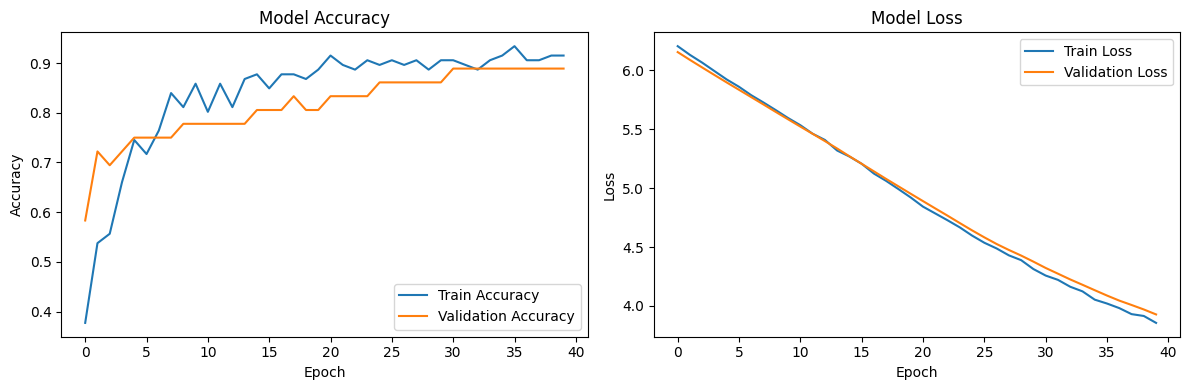

In [6]:
history = model.fit(X_train_reshaped, y_train_encoded,
                    validation_data=(X_val_reshaped, y_val_encoded),
                    epochs=40, batch_size=32, verbose=1)

# Evaluate on test dataset
test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test_encoded, verbose=0)

# Predict on test data
y_pred = model.predict(X_test_reshaped)
y_pred_classes = y_pred.argmax(axis=1)

# Calculate confusion matrix, precision, and recall
conf_matrix = confusion_matrix(y_test_encoded, y_pred_classes)
precision = precision_score(y_test_encoded, y_pred_classes, average='weighted')
recall = recall_score(y_test_encoded, y_pred_classes, average='weighted')

# Print results
print(f"Train Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()